<a href="https://colab.research.google.com/github/llffhh/Stock-Prediction-by-CNN-Study/blob/develop/stock_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install tensorflow_addons
import tensorflow as tf
import numpy as np
import requests
import datetime
import json
import re
import pandas as pd
%matplotlib inline
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import requests
import datetime
import json
import re
import pandas as pd
from lxml import etree



class StockCrawl():
  # set a default parameter
  def __init__(self,name):
    self.name = name+'.TW'
    self.url = 'https://query1.finance.yahoo.com/v7/finance/download/'
    self.start = '?period1='
    self.startdate = str(int(datetime.datetime(2000,1,1).timestamp()))
    self.end = '&period2='
    self.enddate = str(int(datetime.datetime.now().timestamp()))
    self.endhttps = '&interval=1d&events=history&includeAdjustedClose=true'
    self.headers = {'User-Agent':'Mozilla/5.0,Chrome/85.0.4183.102'} #Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36 Edg/85.0.564.51

  # set a date period
  def period(self, startdate=None):
    if startdate == None:
      startdate_re = self.startdate
    else:
      A = startdate.split('-',2)
      startdate_re = str(int(datetime.datetime(int(A[0]),int(A[1]),int(A[2])).timestamp()))
    return startdate_re

  # download the csv data file
  # https://query1.finance.yahoo.com/v7/finance/download/2330.TW?period1=1645285166&period2=1676821166&interval=1d&events=history&includeAdjustedClose=true  for download csv
  def csv_download(self, startdate=None):

    startdate_re = self.period(startdate)
    url_start = 'https://query1.finance.yahoo.com/v7/finance/download/'
    start_period = '?period1='
    end_period = '&period2='
    endhttps = '&interval=1d&events=history&includeAdjustedClose=true'
    url = url_start + self.name + start_period + startdate_re + end_period + self.enddate + endhttps

    # download start
    req = requests.get(url,headers = self.headers)
    open('/content/drive/MyDrive/test.csv', 'w').write(req.text)

    # modify into dataframe type
    req_text = req.text
    req_split = req_text.split("\n")
    data = [i.split(",") for i in req_split[1::]]
    data_columns = req_split[0].split(",")
    df = pd.DataFrame(data, columns=data_columns)
    df = df.set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    # change data type to float16 for Open, High, Low, Close; int32 for Volume and float16 for Adj Close
    df = df.astype({"Open": "float16", "High": "float16", "Low": "float16", "Close": "float16", "Adj Close": "float16", "Volume": "int32"})
    df = df.convert_dtypes()
    dfdn = df.interpolate(method='ffill')
    dfv = dfdn
    print(dfv.dtypes)
    return dfv

  # load page
  # https://finance.yahoo.com/quote/2330.TW/history?period1=946944000&period2=1602633600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'  for scraping
  def loadpage(self, startdate=None):

    startdate_re = self.period(startdate)
    startdate_re = self.period(startdate)
    url_start = 'https://finance.yahoo.com/quote/'
    start_period = '/history?period1='
    end_period = '&period2='
    endhttps = '&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
    url = url_start + self.name + start_period + startdate_re + end_period + self.enddate + endhttps

    # crawler start
    req = requests.get(url,headers = self.headers)
    dfv = self.parsepage(req)
    return dfv

  # parse page
  def parsepage(self,req):
    html = etree.HTML(req.content)
    patternDate = html.xpath("//td[@class='Py(10px) Ta(start) Pend(10px)']/span")
    patternOpen = html.xpath("//td[@class='Py(10px) Pstart(10px)'][1]/span")
    patternHigh = html.xpath("//td[@class='Py(10px) Pstart(10px)'][2]/span")
    patternLow = html.xpath("//td[@class='Py(10px) Pstart(10px)'][3]/span")
    patternClose = html.xpath("//td[@class='Py(10px) Pstart(10px)'][4]/span")
    patternVolume = html.xpath("//td[@class='Py(10px) Pstart(10px)'][6]/span")
    patternAdjclose = html.xpath("//td[@class='Py(10px) Pstart(10px)'][5]/span")

    dataDate = [i.text for i in patternDate]
    dataOpen = [i.text for i in patternOpen]
    dataHigh = [i.text for i in patternHigh]
    dataLow = [i.text for i in patternLow]
    dataClose = [i.text for i in patternClose]
    dataVolume_punc = [i.text for i in patternVolume]
    dataVolume = [i.replace(',','') for i in dataVolume_punc]
    dataAdjclose = [i.text for i in patternAdjclose]

    class dataDateformat():
      def __init__(self):
        self.dataDate_re=[]
        self.dataDateArr=[]
      def Dateformat(self,datalist):
        for i in range(len(datalist)):
          if i == 0:
            self.dataDateArr.append(datalist[i])
          else:
            if datalist[i] == datalist[i-1]:
              pass
            else:
              self.dataDateArr.append(datalist[i])
        self.dataDate_re = self.dataDateArr
        return self.dataDate_re

    class datafloat():
      def __init__(self):
        self.datafloat_re=[]
      def floating(self,datalist):
        for i in datalist:
          if i == "null":
            self.datafloat_re.append(np.NaN)
          else:
            self.datafloat_re.append(round(float(i),2))
        return self.datafloat_re

    dataDate_re = dataDateformat().Dateformat(dataDate)
    dataOpen_re = datafloat().floating(dataOpen)
    dataHigh_re = datafloat().floating(dataHigh)
    dataLow_re = datafloat().floating(dataLow)
    dataClose_re = datafloat().floating(dataClose)
    dataAdjclose_re = datafloat().floating(dataAdjclose)
    dataVolume_re = datafloat().floating(dataVolume)
    
    # dict type
    dataStock={'Date':dataDate_re,'open':dataOpen_re,'high':dataHigh_re,'low':dataLow_re,'close':dataClose_re,'Adj Close':dataAdjclose_re,
               'volume':dataVolume_re}
    dfv = self.writepage(dataStock)
    return dfv

  # write page
  def writepage(self,dataStock):
    df = pd.DataFrame.from_dict(dataStock)
    df = df.sort_index(ascending = False)
    df = df.set_index('Date')
    df.index = pd.DatetimeIndex(df.index)
    dfdn = df.interpolate(method='ffill')
    dfv = dfdn.convert_dtypes()
    dfv.to_csv('/content/drive/MyDrive/'+self.name+'.csv')
    print(dfv)
    return dfv


In [4]:
#@title
import numpy as np
class TechIndicator():
  def __init__(self):
    pass
  
  def WilderSmooth(self,data,day):
    tday = day-1
    AveWSGain = np.zeros(len(data))
    AveWSLoss = np.zeros(len(data))
    Gain = np.zeros(len(data))
    Loss = np.zeros(len(data))
    for i in range(len(data)-1):
      if data.Close[i+1]>=data.Close[i]:
        Gain[i+1] = data.Close[i+1]-data.Close[i]
      else:
        Loss[i+1] = data.Close[i+1]-data.Close[i]
    for i in range(len(data)-tday):
      if i == 0:
        AveWSGain[tday+i] = np.average(Gain[i:tday+1])
        AveWSLoss[tday+i] = np.average(Loss[i:tday+1])
      else:
        AveWSGain[tday+i] = AveWSGain[tday+i-1]+(Gain[tday+i]-AveWSGain[tday+i-1])/(tday+1)
        AveWSLoss[tday+i] = AveWSLoss[tday+i-1]+(Loss[tday+i]-AveWSLoss[tday+i-1])/(tday+1)
    return AveWSGain, AveWSLoss, Gain, Loss


  def RSI(self,data,day):
    #rsi = np.zeros(len(data))
    rsi = np.full(len(data),np.nan)
    AveWSGain,AveWSLoss, Gain, Loss = self.WilderSmooth(data,day)
    RS = AveWSGain/np.abs(AveWSLoss)
    rsi = 100*(RS/(1+RS))
    return rsi
    

  def WilliamR(self,data,day):
    tday = day-1
    #WR = np.zeros(len(data))
    WR = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      WR[tday+i] = ((np.max(data.High[i:tday+i+1])-data.Close[tday+i])
      /(np.max(data.High[i:tday+i+1])-np.min(data.Low[i:tday+i+1])))*(-100)
    return WR
  
  def MA(self,data,day):
    tday = day-1
    #MAt = np.zeros(len(data))
    MAt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      MAt[tday+i] = np.average(data.Close[i:tday+i+1])
    return MAt

  def EMA(self,data,day):  
    tday = day - 1
    EMAt = np.zeros(len(data))
    #EMAt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      if i == 0:
        EMAt[tday+i] = np.average(data.Close[i:tday+i+1])
      else:
        EMAt[tday+i] = EMAt[tday+i-1]+2/(tday+1+1)*(data.Close[tday+i]-EMAt[tday+i-1])
    #EMAt[0:tday] = np.nan
    return EMAt
  
  def WMA(self,data,day):
    tday = day - 1
    #WMAt = np.zeros(len(data))
    WMAt = np.full(len(data),np.nan)
    Wn = np.array(list(range(1,tday+2)))
    for i in range(len(data)-tday):     
      WMAt[tday+i] = np.average(np.array(data.Close[i:tday+i+1]),weights=Wn) 
    return WMAt

  def HMA(self,data,day):
    #HMAt = np.zeros(len(data))
    HMAt = np.full(len(data),np.nan)
    #產生由完整時間區域所產生的HMA
    HMA_f = self.WMA(data,day)
    #產生由一半的時間區域所產生的HMA
    tday = int(np.ceil(day/2))+1
    HMA_h = self.WMA(data,tday)
    HMA_hf = 2*HMA_h - HMA_f
    tday = int(np.ceil(np.sqrt(day)))+1
    data = pd.DataFrame.from_dict({'Close':HMA_hf})
    HMAt = self.WMA(data,tday)
    return HMAt
  
  def TEMA(self,data,day):
    #first time of EMA
    EMAt=self.EMA(data,day)
    data=pd.DataFrame.from_dict({'Close':EMAt})
    #second time of EMA
    EMAtt=self.EMA(data,day)
    data=pd.DataFrame.from_dict({'Close':EMAtt})
    #third time of EMA
    EMAttt=self.EMA(data,day)
    TEMA = 3*EMAt-3*EMAtt+EMAttt
    #TEMA[0:day]=0
    TEMA[0:(day-1)*3]=[np.nan]
    return TEMA

  def CCI(self,data,day):
    '''
    TP = (Close + high + Low)/3
    MA = 20 period SMA of TP 
    CCI = (TP-MA)/(0.015*mean deviation)
    '''
    tday = day-1
    TP = (data.Close+data.High+data.Low)/3
    MA = np.zeros(len(data))
    #MA = np.full(len(data),np.nan)
    MD = np.zeros(len(data))
    #MD = np.full(len(data),np.nan)
    for i in range(len(TP)-tday):
      MDt = [] # initialize the Mean Deviation
      MAt = np.average(TP[i:day+i])
      for j in range(day):
        MDt.append(abs(TP[i+j]-MAt))
      MD[tday+i] = np.average(MDt)
      MA[tday+i] = MAt
    CCI = (TP-MA)/(0.015*MD)
    
    CCI[0:tday]=np.nan
    # print(len(CCI))
    return CCI
  
  def CMO(self,data,day):
    tday = day - 1
    AveWSGain,AveWSLoss, Gain, Loss = self.WilderSmooth(data,day)
    #CMOt = np.zeros(len(data))
    CMOt = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      CMOt[tday+i] = (np.sum(Gain[i:day+i])-abs(np.sum(Loss[i:day+i])))/(np.sum(Gain[i:day+i])+abs(np.sum(Loss[i:day+i])))*100
    return CMOt

  def MACD(self,data,day):
    EMA12 = self.EMA(data,12)
    EMA26 = self.EMA(data,26)
    EMA12[0:25] = [0]
    MACD = EMA12 - EMA26
    signalLine = self.EMA(pd.DataFrame.from_dict({'Close':MACD}),9)
    MACDhist = MACD-signalLine
    MACDhist[0:33] = [np.nan]
    return MACD,signalLine,MACDhist
  
  def PPO(self,data,day): #論文用MA
    PPO = (self.MA(data,12)-self.MA(data,26))/self.MA(data,26)*100
    signalLine = self.EMA(pd.DataFrame.from_dict({'Close':PPO}),9)
    return PPO
  
  def ROC(self,data,day): 
    tday = day - 1
    #ROC = np.zeros(len(data))
    ROC = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      ROC[tday+i] = (data.Close[i+tday]-data.Close[i])/data.Close[i]*100
    return ROC

  def CMFI(self,data,day):    # 12 period
    tday = 12 - 1
    Multiplier = ((data.Close-data.Low)-(data.High-data.Close))/(data.High-data.Low)
    MFV = data.Volume*Multiplier  # Money Flow Volume
    #CMFI = np.zeros(len(data))
    CMFI = np.full(len(data),np.nan)
    for i in range(len(data)-tday):
      CMFI[tday+i] = np.sum(Multiplier[i:tday+i+1])/np.sum(MFV[i:tday+i+1])
    return CMFI  
  
  def DMI(self,data,day):  # still got some problem
    tday = day - 1
    UpMove = np.zeros(len(data))
    DownMove = np.zeros(len(data))
    posDMI = np.zeros(len(data))
    negDMI = np.zeros(len(data))
    TR = np.zeros(len(data))
    #TR = np.full(len(data),np.nan)
    tt = 1
    for i in range(len(data)-tt):
      UpMove[tt+i] = data.High[i+tt] - data.High[i]
      DownMove[tt+i] = data.Low[i] - data.Low[i+tt]
      if UpMove[tt+i]>DownMove[tt+i] and UpMove[tt+i]>0:
        posDMI[tt+i] = UpMove[tt+i]
      else:
        posDMI[tt+i] = 0

      if DownMove[tt+i]>UpMove[tt+i] and DownMove[tt+i]>0:
        negDMI[tt+i] = DownMove[tt+i]
      else:
        negDMI[tt+i] = 0

      if posDMI[tt+i]>negDMI[tt+1]:
        negDMI[tt+i] = 0
      else:
        posDMI[tt+i] = 0
      TRprice = [data.High[tt+i]-data.Low[tt+i], data.High[tt+i]-data.Close[i], data.Low[tt+i]-data.Close[i]]
      TR[tt+i] = np.max(np.abs(TRprice))
      
    posDI = 100*self.EMA(pd.DataFrame.from_dict({'Close':posDMI}),day)/self.EMA(pd.DataFrame.from_dict({'Close':TR}),day)
    negDI = 100*self.EMA(pd.DataFrame.from_dict({'Close':negDMI}),day)/self.EMA(pd.DataFrame.from_dict({'Close':TR}),day)
    DX = abs((posDI-negDI)/(posDI+negDI))*100
    DX[0:tday] = 0
    ADX = self.EMA(pd.DataFrame.from_dict({'Close':DX}),day)
    ADX[0:tday] = np.nan
    return posDI,negDI,ADX,DX,posDMI,negDMI

  def SAR(self,data,day):
    def RPSAR(PSAR,AF,EP):
      RPSAR = PSAR + AF*(EP-PSAR)
      return RPSAR
    def FPSAR(PSAR,AF,EP):
      FPSAR = PSAR - AF*(PSAR-EP)
      return FPSAR
      
    [AF,AF_max] = [0.02,0.2]
    #SAR = np.zeros(len(data))
    SAR = np.full(len(data),np.nan)
    period = 5
    tt = period - 1
    for i in range(len(data)-tt):
      if i == 0:
        if dataStock.Close[i+tt]>dataStock.Close[i]: #uptrend
          PSAR = np.min(dataStock.Low[i:i+period])
          EP = np.max(dataStock.High[i:i+period])
        else:
          PSAR = np.max(dataStock.High[i:i+period])
          EP = np.min(dataStock.Low[i:i+period])
      else:
        if dataStock.Close[i+tt]>PSAR:       #uptrend
          PSAR = RPSAR(PSAR,AF,EP)
          if dataStock.Close[i+tt-1]<PSAR:
            AF = 0.02
          if dataStock.High[i+tt]>EP:
            if AF >= AF_max:
              AF = 0.2
            else:
              AF += 0.04
            EP = dataStock.High[i+tt]
        else:                               #downtrend
          PSAR = FPSAR(PSAR,AF,EP)
          if dataStock.Close[i+tt-1]>PSAR:
            AF = 0.02
          if dataStock.Low[i+tt]<EP:
            if AF >= AF_max:
              AF = 0.2
            else:
              AF += 0.04
            EP = dataStock.Low[i+tt]
      SAR[i+tt] = PSAR
    return SAR

In [5]:
import numpy as np
import math

# -1 sell; 0 hold; 1 buy
class triple_barrier():
  '''
  example:
  ret = triple_barrier.triple_barrier(dataStock.Close, 1.1, 0.95, 10)
  StockTechRet=pd.concat([StockTech,ret],axis=1)
  '''
  def __init__(self):
    pass

  def triple_barrier(data, ub, lb, max_period):

      price = data.Close

      def end_price(s):
          return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
      
      r = np.array(range(max_period))
      
      def end_time(s):
          return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

      p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
      

      
      t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
      t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                    for i, k in enumerate(t)], index=t.index).dropna()

      signal = pd.Series(0, p.index)
      signal.loc[p > ub] = 1
      signal.loc[p < lb] = -1
      
      # ret = pd.DataFrame(dataStock.index)
      ret = pd.DataFrame(data.index)
      ret = ret.set_index('Date')
      ret['triple_barrier_profir'] = p
      ret['triple_barrier_sell_time'] = t
      ret['triple_barrier_signal'] = signal
      ret['triple_barrier_Close'] = data.Close

      return ret



In [6]:
class FinancialTesting():
  '''
  FinancialTesting(data, period, cash, eachStock, triple_barrier_period, passlosssignal)
  period = How long do we buy the stock
  cash = Initial Cash
  eachStock = How many stock do we buy per time
  triple_barrier_period = The period we set in triple barrier function
  passlosssignal = if 1, mean we don't buy any stock when the signal is stop loss signal
  '''
  def __init__(self, data, period, cash, eachStock, triple_barrier_period, passlosssignal):   
    self.period = period
    self.stockNumber = 0
    self.StockValue = 0
    self.Cash = cash
    self.EachTime = eachStock # 100 stock
    self.signalRecord = []
    self.CashList = []
    self.StockCost = 0
    self.StockTechRet_Nonan = data
    self.passlosssignal = passlosssignal
    self.triple_barrier_period = triple_barrier_period
    self.buying_price = []
    self.selling_price = []
    
  def buying(self, signal, stockcost_eachTime):
    # print("Buying signal is triggered ({} period), signal: {}".format(self.period, signal))
    self.Cash -= stockcost_eachTime
    self.stockNumber += self.EachTime
    self.StockCost += stockcost_eachTime
    self.signalRecord.append(signal)
    # print("Buying price: {}, Cash: {}".format(self.StockTechRet_Nonan.Close[i],self.Cash))

  def sellingsignal(self, signal, stockcost_eachTime, futureTime):
    difference = self.StockTechRet_Nonan.Close[futureTime]*self.EachTime-stockcost_eachTime
    self.Cash += difference + stockcost_eachTime
    self.StockCost -= self.StockTechRet_Nonan.Close[i]*self.EachTime
    self.stockNumber -= self.EachTime
    return difference

  def process(self):
    for i in range(len(self.StockTechRet_Nonan)-self.triple_barrier_period):
      futureTime = self.StockTechRet_Nonan.triple_barrier_sell_time[i]
      signal = self.StockTechRet_Nonan.triple_barrier_signal[i]
      # Buy the Stock after a specific period and calculate the profit we make after specific period
      if i == 0 or (i+1)%self.period==0:
        if signal == 1: #stop profit
          stockcost_eachTime = self.StockTechRet_Nonan.Close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.buying_price.append(self.StockTechRet_Nonan.Close[i])
          self.selling_price.append(self.StockTechRet_Nonan.Close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Profit: {}\n'.format(self.StockTechRet_Nonan.Close[futureTime], self.Cash, difference))
        elif signal == -1 and self.passlosssignal == 0: #stop loss        
          stockcost_eachTime = self.StockTechRet_Nonan.Close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.buying_price.append(self.StockTechRet_Nonan.Close[i])
          self.selling_price.append(self.StockTechRet_Nonan.Close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Loss: {}\n'.format(self.StockTechRet_Nonan.Close[futureTime], self.Cash, difference))
        elif signal == 0:
          stockcost_eachTime = self.StockTechRet_Nonan.Close[i]*self.EachTime
          self.buying(signal, stockcost_eachTime)
          self.buying_price.append(self.StockTechRet_Nonan.Close[i])
          # difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
      # Calculate the profit\loss we make when hold signal is triggered, stock number equal to each stock
      if self.stockNumber > 0:  
        # print("Holding signal is triggered and the signal now: {}".format(signal))
        # print("Future price (holding signal): {}".format(self.StockTechRet_Nonan.Close[futureTime]))
        if self.StockTechRet_Nonan.triple_barrier_signal[i] == 1:
          stockcost_eachTime = self.StockCost/self.stockNumber*self.EachTime
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.selling_price.append(self.StockTechRet_Nonan.Close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Profit: {}\n'.format(self.StockTechRet_Nonan.Close[futureTime], self.Cash, difference))
        elif self.StockTechRet_Nonan.triple_barrier_signal[i] == -1:
          stockcost_eachTime = self.StockCost/self.stockNumber*self.EachTime
          difference = self.sellingsignal(signal, stockcost_eachTime, futureTime)
          self.selling_price.append(self.StockTechRet_Nonan.Close[futureTime])
          # print('Selling price: {}, Cash: {}, Stop Loss: {}\n'.format(self.StockTechRet_Nonan.Close[futureTime], self.Cash, difference))
        
      self.CashList.append(self.Cash)
      self.StockValue = self.stockNumber * self.StockTechRet_Nonan.Close[i]

    print('The buying signal in these days: {}'.format(self.signalRecord))
    print('Buying price: {}'.format(self.buying_price))
    print('Selling price: {}'.format(self.selling_price))
    # print("Count -1: {}; Count 0: {}; Count 1: {}".format(self.signalRecord.count(-1), self.signalRecord.count(0), self.signalRecord.count(1)))

    print('Cash: {}'.format(np.floor(self.Cash)))
    # print('As we still have {} stock, therefore the Stock Value now is {}'.format(self.stockNumber, self.StockValue))

# FinancialTesting(StockTechRet_Nonan, 20, 10000, 1, 20, 1).process()

In [7]:
def plot_confusion_matrix(cm,
             target_names,
             title='Confusion matrix',
             cmap=None,
             normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm = cm                  # confusion matrix created by sklearn.metrics.confusion_matrix
               normalize = True,             # show proportions
               target_names = y_labels_vals,       # list of names of the classes
               title = best_estimator_name)        # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [130]:
PdFrame

,RSI_6,WilliamR_6,WMA_6,EMA_6,MA_6,HMA_6,TEMA_6,CCI_6,CMO_6,MACD_6,...,HMA_20,TEMA_20,CCI_20,CMO_20,MACD_20,PPO_20,ROC_20,CMFI_20,DMI_20,SAR_20
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,58.182458,-50.549451,50.163690,49.955016,49.963542,50.403244,50.182933,-24.096386,-8.943089,0.210904,...,51.007969,51.260382,61.892409,59.913793,0.210904,7.675220,20.606061,6.116991e-09,37.875505,49.972390
2023-02-14,65.028566,-27.472527,50.290179,50.083940,50.187500,50.417054,50.291128,38.084112,38.738739,0.144396,...,51.078259,51.391607,73.650739,61.169102,0.144396,7.713706,18.865144,5.942904e-09,36.959163,50.215412
2023-02-15,56.562261,-63.076923,50.209821,50.033171,50.312500,50.260298,50.019150,-48.611111,19.354839,0.047595,...,51.054603,51.341251,62.116639,52.401747,0.047595,7.100589,12.148876,6.716373e-09,35.664595,50.234854


In [8]:
# Preprocessing
#download stock information
dataStock = StockCrawl('2303').csv_download('2020-01-01')

#Calculate the techincal indicator
PdFrame = pd.DataFrame(dataStock.index)
PdFrame = PdFrame.set_index('Date')

for i in range(6,21):
  PdFrame["RSI_%d"%i]=TechIndicator().RSI(dataStock,i)
  PdFrame["WilliamR_%d"%i]=TechIndicator().WilliamR(dataStock,i)
  PdFrame["WMA_%d"%i]=TechIndicator().WMA(dataStock,i)
  PdFrame["EMA_%d"%i]=TechIndicator().EMA(dataStock,i)
  PdFrame["MA_%d"%i]=TechIndicator().MA(dataStock,i)
  PdFrame["HMA_%d"%i]=TechIndicator().HMA(dataStock,i)
  PdFrame["TEMA_%d"%i]=TechIndicator().TEMA(dataStock,i)
  PdFrame["CCI_%d"%i]=TechIndicator().CCI(dataStock,i)
  PdFrame["CMO_%d"%i]=TechIndicator().CMO(dataStock,i)
  PdFrame["MACD_%d"%i]=TechIndicator().MACD(dataStock,i)[2]
  PdFrame["PPO_%d"%i]=TechIndicator().PPO(dataStock,i)
  PdFrame["ROC_%d"%i]=TechIndicator().ROC(dataStock,i)
  PdFrame["CMFI_%d"%i]=TechIndicator().CMFI(dataStock,i)
  PdFrame["DMI_%d"%i]=TechIndicator().DMI(dataStock,i)[2]
  PdFrame["SAR_%d"%i]=TechIndicator().SAR(dataStock,i)
  print("period: {}".format(i))
 
StockTech = pd.concat([dataStock,PdFrame],axis = 1)
StockTech.to_csv('/content/drive/MyDrive/StockTech.csv')

Open         Float64
High         Float64
Low          Float64
Close        Float64
Adj Close    Float64
Volume         Int32
dtype: object


<ipython-input-4-6b3c737fced9>:32: RuntimeWarning: invalid value encountered in true_divide
  RS = AveWSGain/np.abs(AveWSLoss)
<ipython-input-4-6b3c737fced9>:199: RuntimeWarning: invalid value encountered in true_divide
  posDI = 100*self.EMA(pd.DataFrame.from_dict({'Close':posDMI}),day)/self.EMA(pd.DataFrame.from_dict({'Close':TR}),day)
<ipython-input-4-6b3c737fced9>:200: RuntimeWarning: invalid value encountered in true_divide
  negDI = 100*self.EMA(pd.DataFrame.from_dict({'Close':negDMI}),day)/self.EMA(pd.DataFrame.from_dict({'Close':TR}),day)


period: 6
period: 7
period: 8
period: 9
period: 10
period: 11


<ipython-input-8-5f6d9fa60499>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  PdFrame["PPO_%d"%i]=TechIndicator().PPO(dataStock,i)
<ipython-input-8-5f6d9fa60499>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  PdFrame["ROC_%d"%i]=TechIndicator().ROC(dataStock,i)
<ipython-input-8-5f6d9fa60499>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de

period: 12


<ipython-input-8-5f6d9fa60499>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  PdFrame["WilliamR_%d"%i]=TechIndicator().WilliamR(dataStock,i)
<ipython-input-8-5f6d9fa60499>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  PdFrame["WMA_%d"%i]=TechIndicator().WMA(dataStock,i)
<ipython-input-8-5f6d9fa60499>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  T

period: 13
period: 14
period: 15
period: 16
period: 17
period: 18
period: 19
period: 20


In [204]:
img_StockTechRet_Nonan_TechInd_Nom[403]

[[-1.0,
  -0.349706641823726,
  0.09419657475874921,
  0.39502672649230064,
  0.5975377214374671,
  0.733071358615101,
  0.8233382791449397,
  0.8832426255125494,
  0.92294555771171,
  0.9493364742740358,
  0.9670630478713562,
  0.9792437832049412,
  0.9879573495625369,
  0.9945772175617194,
  1.0],
 [-1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -0.65501498073905,
  -0.65501498073905,
  -0.65501498073905,
  0.21717791411042953,
  0.6345548001989723,
  0.795836266720306,
  0.795836266720306,
  0.8781599866319736,
  1.0000000000000002],
 [-0.10734422953396461,
  0.37156519877237315,
  0.7006518687697394,
  0.868270168676986,
  0.9835129541074252,
  1.0,
  0.9314000538038272,
  0.8661765755477404,
  0.8049389765184287,
  0.7217186496324075,
  0.5444020874354578,
  0.2434865602796208,
  -0.12056692298159533,
  -0.529272113264426,
  -1.0],
 [0.9581190956309626,
  1.0,
  0.9667966277986011,
  0.8766931450771267,
  0.7453063690145711,
  0.5855993489207663,
  0.4080402770375997,
  0.2208651

In [1]:
img_StockTechRet_Nonan_TechInd_Nom = []
j=1
for i in StockTechRet_Nonan_TechInd_Nom:
  print(j)
  img_StockTechRet_Nonan_TechInd_Nom.append(np.transpose(scaler.fit_transform(i.reshape((15,15)))).tolist())
  j=j+1
# StockTechRet_Nonan['img'] = img_StockTechRet_Nonan_TechInd_Nom
listData = []
listLabel = []
# for i in range(len(StockTechRet_Nonan_TechInd_Nom)):
#   listData.append(StockTechRet_Nonan.img.values[i])
#   listLabel.append(StockTechRet_Nonan.triple_barrier_signal.values[i])
# listData = np.array(listData).reshape(len(StockTechRet_Nonan_TechInd_Nom),15,15,1)
# listLabel = np.array(listLabel).reshape(len(StockTechRet_Nonan_TechInd_Nom),1)
# print("change to img type")

NameError: ignored

<ipython-input-9-5b295303c2bf>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  StockTech['datestamp'] = datestamp


                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2020-04-09  14.296875  14.398438  14.101562  14.203125  12.296875  40473210   
2020-04-10      14.25  14.296875  14.148438  14.296875  12.382812  23315732   
2020-04-13  14.453125  15.101562  14.398438  14.796875  12.820312  94375364   
2020-04-14  15.046875  15.148438  14.851562  15.148438  13.117188  70873919   
2020-04-15  15.148438  15.203125  14.898438  15.101562  13.078125  76800916   
...               ...        ...        ...        ...        ...       ...   
2023-02-13    50.1875    50.1875   49.15625      49.75      49.75  58610023   
2023-02-14    50.1875    50.6875       50.0   50.40625   50.40625  38055955   
2023-02-15   49.90625   50.59375      49.75   49.90625   49.90625  54088246   
2023-02-16   50.40625       50.5    49.6875   50.09375   50.09375  56240350   
2023-02-17   49.65625    50.1875   49.34375       50

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All

change to img type


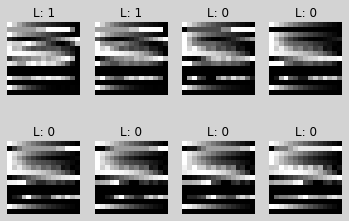

Percentage of class -1 = 33.035714285714285, class 0 = 22.991071428571427, class 1 = 43.973214285714285


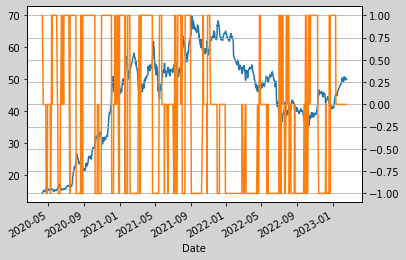

In [9]:
#Filter the all the Nan data or select the date we need
datestamp = []
for i in range(len(StockTech.index)):
  datestamp.append(int(datetime.datetime.timestamp(StockTech.index[i])))
StockTech['datestamp'] = datestamp
# StockTech_Nonan = StockTech.loc[StockTech.datestamp>datetime.datetime.strptime('2020-01-01','%Y-%m-%d').timestamp()]
StockTech_Nonan = StockTech.iloc[60:len(StockTech),:]
StockTech_Nonan.to_csv('/content/drive/MyDrive/StockTech_Nonan.csv')
print(StockTech_Nonan)

#label the data and take out the Technical indicator and the label
ret = triple_barrier.triple_barrier(StockTech_Nonan, 1.1, 0.95, 20)
StockTechRet_Nonan = pd.concat([StockTech_Nonan,ret],axis=1)
StockTechRet_Nonan_TechInd = StockTechRet_Nonan.iloc[:len(StockTechRet_Nonan),6:15*15+6]


#Nomarlized (Min-Max Scaled)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
# StockTechRet_Nonan_TechInd_Nom = scaler.fit_transform(StockTechRet_Nonan_TechInd)
StockTechRet_Nonan_TechInd_Nom = np.array(StockTechRet_Nonan_TechInd)


#change to pic size and input type
img_StockTechRet_Nonan_TechInd_Nom = []
for i in range(len(StockTechRet_Nonan_TechInd_Nom)):
  img_StockTechRet_Nonan_TechInd_Nom.append(np.transpose(scaler.fit_transform(StockTechRet_Nonan_TechInd_Nom[i].reshape((15,15)))).tolist())
StockTechRet_Nonan['img'] = img_StockTechRet_Nonan_TechInd_Nom
listData = []
listLabel = []
for i in range(len(StockTechRet_Nonan_TechInd_Nom)):
  listData.append(StockTechRet_Nonan.img.values[i])
  listLabel.append(StockTechRet_Nonan.triple_barrier_signal.values[i])
listData = np.array(listData).reshape(len(StockTechRet_Nonan_TechInd_Nom),15,15,1)
listLabel = np.array(listLabel).reshape(len(StockTechRet_Nonan_TechInd_Nom),1)
print("change to img type")

# train set and test set, 20天訓練，10天測試 
from sklearn.model_selection import train_test_split
# train_x, train_y, test_x, test_y  = [], [], [], []
# for i in range(int(np.floor((len(StockTechRet_Nonan)-30)/10))):
#   train_x.append(StockTechRet_Nonan.img[i*10:20+i*10])
#   train_y.append(StockTechRet_Nonan.triple_barrier_signal[i*10:20+i*10])
#   test_x.append(StockTechRet_Nonan.img[20+i*10:20+i*10+10])
#   test_y.append(StockTechRet_Nonan.triple_barrier_signal[20+i*10:20+i*10+10])
data_StockTechRet = StockTechRet_Nonan['img'].values
label_StockTechRet = StockTechRet_Nonan['triple_barrier_signal'].values
train_x, test_x, train_y, test_y = train_test_split(listData, listLabel, train_size=0.8, test_size=0.2, random_state=2, shuffle=False)
train_x, cv_x, train_y, cv_y = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2, random_state=2, shuffle=False)

# output pic example
import matplotlib.pyplot as plt
picNumber = 8
images_labels = list(zip(StockTechRet_Nonan.img.values,StockTechRet_Nonan.triple_barrier_signal.values))
for i, (image, label) in enumerate(images_labels[0:8]):
  plt.figure('Img & Signal Diagram',facecolor = 'lightgray')
  plt.subplot(2,4,i+1)
  plt.axis('off')
  plt.imshow(image, cmap = 'gray')
  plt.title('L: '+ str(label))
plt.show()

# calculate the number of hold, buy and sell
_labels, _counts = np.unique(train_y, return_counts = True)
if np.size(_labels) == 3:
  print("Percentage of class -1 = {}, class 0 = {}, class 1 = {}".format(_counts[0]/len(train_y)*100, _counts[1]/len(train_y)*100, _counts[2]/len(train_y)*100))
else:
  print("Percentage of class -1 = {}, class 0 = {}, class 1 = {}".format(_counts[0]/len(train_y)*100, _counts[1]/len(train_y)*100, 0))

# plot the final data curve
import matplotlib.pyplot as mp
mp.figure('Stock Diagram',facecolor = 'lightgray')
StockTechRet_Nonan.Close.plot()
StockTechRet_Nonan.triple_barrier_signal.plot(secondary_y=True)

mp.grid()

In [53]:
listData[333]

array([[[-1.        ],
        [-0.51369664],
        [-0.15881776],
        [ 0.10581369],
        [ 0.30723462],
        [ 0.46325552],
        [ 0.58583957],
        [ 0.68322983],
        [ 0.76126167],
        [ 0.82417551],
        [ 0.87512758],
        [ 0.91651737],
        [ 0.95020242],
        [ 0.97764268],
        [ 1.        ]],

       [[-0.87985215],
        [-0.93149942],
        [-0.99436388],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.67633534],
        [ 0.28847779],
        [ 0.94377482],
        [ 0.94377482],
        [ 0.94377482],
        [ 0.94377482],
        [ 0.94377482],
        [ 1.        ]],

       [[-1.        ],
        [-0.58587581],
        [-0.17816762],
        [ 0.24509452],
        [ 0.57034197],
        [ 0.8013607 ],
        [ 0.93081479],
        [ 1.        ],
        [ 0.98126346],
        [ 0.86950826],
        [ 0.71274835],
        [ 0.53426094],
        [ 0.33448886],
       

In [14]:
from keras.models import Sequential  #用來啟動 NN
from keras.layers import Conv2D  # Convolution Operation
from keras.layers import MaxPooling2D # Pooling
from keras.layers import Flatten
from keras.layers import Dense # Fully Connected Networks
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
import tensorflow as tf
import tensorflow_addons as tfa



class Model():
  def __init__():
    pass

  # Build CNN
  def net():
    net = Sequential()
    net.add(Conv2D(32,(3,3), strides=(2,2), activation='relu', padding="same", use_bias=False, input_shape=(15,15,1)))
    net.add(Conv2D(64,(3,3), strides=(2,2), activation='relu', padding="same", use_bias=False))
    net.add(MaxPooling2D(2, strides=2))
    net.add(Dropout(0.25))
    net.add(Flatten())
    net.add(Dense(128,activation = None))
    net.add(Dropout(0.5))
    net.add(Dense(3,activation='softmax'))
    opt = tf.keras.optimizers.Adam(0.0001, clipnorm=1.)
    net.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["acc"])
    return net

  def net1(lr, total_step, warmup_proportion, min_lr):
    # Ranger optimizer 
    radam = tfa.optimizers.RectifiedAdam(lr=lr, total_steps=total_step, warmup_proportion=warmup_proportion, min_lr=min_lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    net1 = Sequential()
    net1.add(Conv2D(32,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False,input_shape=(15,15,1)))
    net1.add(BatchNormalization())
    # net1.add(Dropout(0.25))
    net1.add(Conv2D(64,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False))
    net1.add(BatchNormalization())
    net1.add(Dropout(0.25))
    net1.add(Conv2D(128,(3,3),strides=(2,2),activation=LeakyReLU(alpha=0.1),padding="same", use_bias=False))
    net1.add(BatchNormalization())
    # net1.add(Dropout(0.25))
    net1.add(MaxPooling2D(2,strides=2))
    net1.add(Dropout(0.25))
    net1.add(Flatten())
    net1.add(Dense(128,activation = None))
    net1.add(Dropout(0.5))
    net1.add(Dense(3,activation='softmax'))
    net1.compile(loss="categorical_crossentropy", optimizer = ranger, metrics=["acc"])
    return net1



ValueError: ignored

<Figure size 792x288 with 0 Axes>

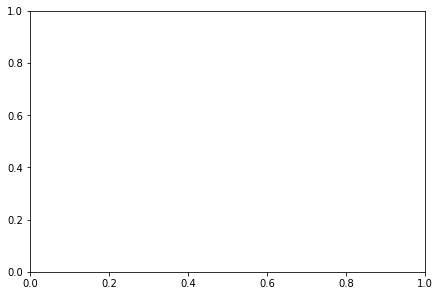

In [22]:
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.Close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price,label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')
# ax.xaxis.set_major_locator(mdates.MonthLocator(date))
mp.grid()

In [47]:
for i in range(len(train_x)):
  print(f'{i}: {np.sum(train_x[i])}')


0: -60.21122524254415
1: -75.03700492384093
2: -84.10383673589274
3: -95.92745966068753
4: -75.5007600990837
5: -74.02696671664087
6: -72.38721549439309
7: -53.40400927256001
8: -29.006901225807965
9: -31.685437813504628
10: -52.1999958901724
11: -52.84355630435691
12: -56.81968419472054
13: -54.01646023069589
14: -52.573745509482855
15: -46.9083018704911
16: -39.32916565658738
17: -41.521720251873205
18: -47.176489643642405
19: -72.0702274133529
20: -74.57598679868033
21: -68.90618329772678
22: -58.46814369155104
23: -68.68323481724464
24: -47.58574379556809
25: -50.358370767608136
26: -38.56955332720362
27: -46.20576318955843
28: -46.21709936049399
29: -70.31790778475951
30: -61.54054989279685
31: -59.62166198740013
32: -76.58800930620743
33: -77.14606221494354
34: -94.21768128270524
35: -91.72900684821381
36: -87.08966185197158
37: -106.27399247624248
38: -101.8769677067772
39: -76.54388518077515
40: -72.38036703742824
41: -69.8502078499155
42: -54.19869929747195
43: -35.71037106469

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 8, 8, 32)          288       
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          18432     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 2, 2, 64)          0         
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

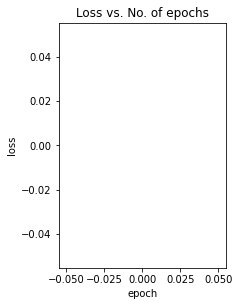

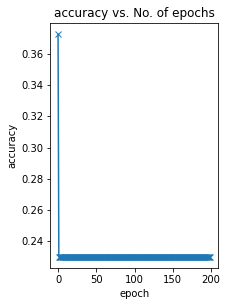

<Figure size 792x288 with 0 Axes>

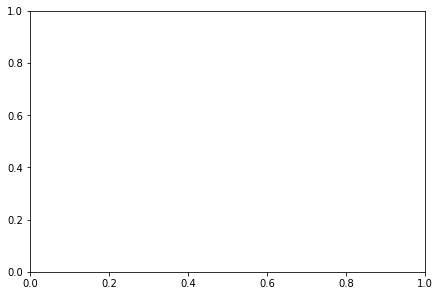

In [34]:
# Postprocessing
# Print Model
print(Model.net().summary())

# Training progress
print("===============Training Process===============")
from keras import utils
ten_y=utils.to_categorical(train_y,3)
train_history = Model.net().fit(x=train_x,y=ten_y,batch_size=20,epochs=20,shuffle=False)

# validation progress
print("===============Validation Process===============")
from keras import utils
list_cv_y=utils.to_categorical(cv_y,3)

list_cv_x=[]
for i in range(len(cv_x)):
  list_cv_x.append(cv_x[i].tolist())
list_cv_x=np.array(list_cv_x).reshape(len(list_cv_x),15,15,1)
validation_loss, validation_acc = Model.net().evaluate(list_cv_x,list_cv_y)
print("Validation Loss = {}, Validation Acc. = {}".format(validation_loss,validation_acc))

# Predict progress
print("===============Prediction Process===============")
list_test_y=utils.to_categorical(test_y,3)  # 0, 1, -1

list_test_x=[]
for i in range(len(test_x)):
  list_test_x.append(test_x[i].tolist())
list_test_x=np.array(list_test_x).reshape(len(test_x),15,15,1)

pre_y = Model.net().predict(list_test_x)
# As pre_y have 3 column therefore there will have 0,1,2 after calculate as np.argmax.
# Moreover, our label is 0, 1, -1. So we need to change the 2 to -1 when do the F1 score
pre_y_label=np.argmax(pre_y,axis=1)

for i in range(len(pre_y_label)):
  if pre_y_label[i]==2:
    pre_y_label[i]=-1

from sklearn.metrics import classification_report
print(classification_report(test_y, pre_y_label))


# losses = [x['loss'] for x in train_history.history]
losses = list(train_history.history['loss'])
accuracies = list(train_history.history['acc'])
plt.figure(facecolor='white',figsize=(3,4.5))
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
plt.figure(facecolor='white',figsize=(3,4.5))
plt.plot(accuracies, '-x')
plt.xlabel('epoch',)
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

# draw the signal and pred_y_label
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.Close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price,label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')
# ax.xaxis.set_major_locator(mdates.MonthLocator(date))
mp.grid()

# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],20,1000,1,20,1).process()
Pred_DataFrame = pd.DataFrame(StockTechRet_Nonan.index[start:end])
Pred_DataFrame = Pred_DataFrame.set_index('Date')
Pred_DataFrame['Close'] = StockTechRet_Nonan.Close[start:end]
Pred_DataFrame['triple_barrier_sell_time'] = StockTechRet_Nonan.triple_barrier_sell_time[start:end]
Pred_DataFrame['triple_barrier_signal'] = pre_y_label
FinancialTesting(Pred_DataFrame,20,1000,1,20,1).process()

# Plot the Confusion Matrix
# plot_confusion_matrix(ConfusionMatrix, normalize = False, target_names = ['stop loss', 'hold', 'stop profit'], title = "Confusion Matrix")

TypeError: ignored

<Figure size 792x288 with 0 Axes>

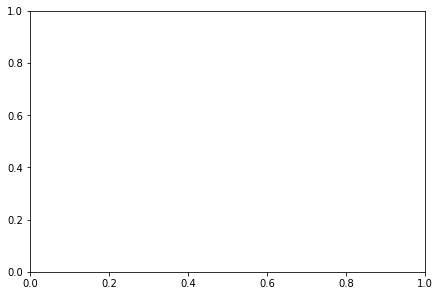

In [ ]:
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.Close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(StockTechRet_Nonan.Close[start:end], y='Close',label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')

In [ ]:

price = StockTechRet_Nonan.Close[start:end]
print(price)

Date
2023-02-01    49.25
2023-02-02     50.4
2023-02-03     50.1
2023-02-06    49.05
2023-02-07    49.15
2023-02-08     50.5
2023-02-09     50.5
2023-02-10     50.8
Name: close, dtype: Float64


In [ ]:
# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],1,1000,1,20,1).process()
FinancialTesting(Pred_DataFrame,1,1000,1,20,1).process()

The buying signal in these days: []
Buying price: []
Selling price: []
Cash: 1000.0


NameError: ignored

In [153]:
#from keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
# Model Summary
lr=1e-3
total_steps=10000
warmup_proportion=0.1
min_lr=1e-5
print(Model.net1(lr,total_steps,warmup_proportion,min_lr).summary())

# train
print("===============Training Process===============")
#ten_y=utils.to_categorical(train_y,3)
ten_y=to_categorical(train_y,3)
train_history1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).fit(x=train_x,y=ten_y,batch_size=2000,epochs=1300,shuffle=False)

# validation
print("===============Validation Process===============")
#list_cv_y=utils.to_categorical(cv_y,3)
list_cv_y=to_categorical(cv_y,3)
list_cv_x=[]
for i in range(len(cv_x)):
  list_cv_x.append(cv_x[i].tolist())
list_cv_x=np.array(list_cv_x).reshape(len(list_cv_x),15,15,1)
validation_loss1, validation_acc1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).evaluate(list_cv_x,list_cv_y)
print("Validation Loss = {}, Validation Acc. = {}".format(validation_loss1,validation_acc1))

# predict
print("===============Prediction Process===============")
list_test_y=to_categorical(test_y,3)  # 0, 1, -1

list_test_x=[]
for i in range(len(test_x)):
  list_test_x.append(test_x[i].tolist())
list_test_x=np.array(list_test_x).reshape(len(test_x),15,15,1)
pre_y1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).predict(list_test_x)
pre_y_label1=np.argmax(pre_y1,axis=1)
# change the label from 2 into -1
for i in range(len(pre_y_label1)):
  if pre_y_label1[i]==2:
    pre_y_label1[i]=-1
print(classification_report(test_y, pre_y_label1))

# draw the accuracy and the loss
losses1 = list(train_history1.history['loss'])
accuracies1 = list(train_history1.history['acc'])
plt.figure(facecolor='white',figsize=(3,4.5))
plt.plot(losses1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
plt.figure(facecolor = 'white',figsize=(3,4.5))
plt.plot(accuracies1, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');


# draw the signal and pred_y_label
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.Close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label1
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price,label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')
mp.grid()

# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],10,1000,1,20,1).process()
Pred_DataFrame = pd.DataFrame(StockTechRet_Nonan.index[start:end])
Pred_DataFrame = Pred_DataFrame.set_index('Date')
Pred_DataFrame['Close'] = StockTechRet_Nonan.Close[start:end]
Pred_DataFrame['triple_barrier_sell_time'] = StockTechRet_Nonan.triple_barrier_sell_time[start:end]
Pred_DataFrame['triple_barrier_signal'] = pre_y_label1
FinancialTesting(Pred_DataFrame,10,1000,1,20,1).process()

# Plot the Confusion Matrix
# plot_confusion_matrix(ConfusionMatrix1, normalize = False, target_names = ['stop loss', 'hold', 'stop profit'], title = "Confusion Matrix")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 8, 8, 32)          288       
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          18432     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 2, 128)        

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 1, 1, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 110,243
Trainable params: 109,795
Non-trainable params: 448
_________________________________________________________________
None
===============Training Process===============
Epoch 1/1300
1/1

KeyboardInterrupt: ignored

===============Prediction Process===============


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


              precision    recall  f1-score   support

          -1       0.28      0.66      0.40        56
           0       0.40      0.25      0.31        76
           1       0.00      0.00      0.00        50

    accuracy                           0.31       182
   macro avg       0.23      0.30      0.23       182
weighted avg       0.25      0.31      0.25       182

The buying signal in these days: [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
Buying price: [54.0, 53.4, 46.5, 52.2, 52.6, 57.8, 57.6, 61.7, 56.4, 63.1, 63.1]
Selling price: [61.8, 61.8, 51.9, 50.8, 50.8, 63.4, 64.1, 70.0, 62.5]
Cash: 918.0
The buying signal in these days: [0, 0, 0]
Buying price: [61.7, 65.3, 56.4]
Selling price: [70.0, 58.5, 62.5]
Cash: 1007.0


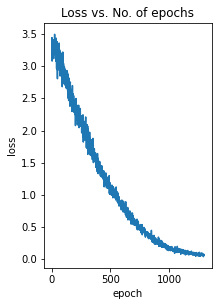

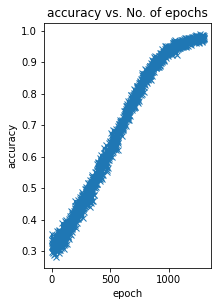

<Figure size 792x288 with 0 Axes>

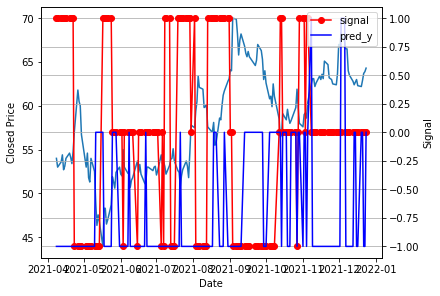

In [ ]:
# predict
print("===============Prediction Process===============")
list_test_y=to_categorical(test_y,3)  # 0, 1, -1

list_test_x=[]
for i in range(len(test_x)):
  list_test_x.append(test_x[i].tolist())
list_test_x=np.array(list_test_x).reshape(len(test_x),15,15,1)
pre_y1 = Model.net1(lr,total_steps,warmup_proportion,min_lr).predict(list_test_x)
pre_y_label1=np.argmax(pre_y1,axis=1)
# change the label from 2 into -1
for i in range(len(pre_y_label1)):
  if pre_y_label1[i]==2:
    pre_y_label1[i]=-1
print(classification_report(test_y, pre_y_label1))

# draw the accuracy and the loss
losses1 = list(train_history1.history['loss'])
accuracies1 = list(train_history1.history['acc'])
plt.figure(facecolor='white',figsize=(3,4.5))
plt.plot(losses1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');
plt.figure(facecolor = 'white',figsize=(3,4.5))
plt.plot(accuracies1, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');


# draw the signal and pred_y_label
plt.figure(facecolor='white',figsize=(11,4))
start = len(StockTechRet_Nonan)-len(test_x)
end = len(StockTechRet_Nonan)
price = StockTechRet_Nonan.Close[start:end]
date = StockTechRet_Nonan.index[start:end]
signal = StockTechRet_Nonan.triple_barrier_signal[start:end]
predy = pre_y_label1
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(date,price,label='price')
ax1 = ax.twinx()
ax1.plot(date,signal,'r',marker = 'o',label = "signal")
ax1.plot(date,predy,'b',label = 'pred_y')
ax1.legend(loc = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Closed Price')
ax1.set_ylabel('Signal')
mp.grid()

# Calculate the Financial Result
FinancialTesting(StockTechRet_Nonan[start:end],10,1000,1,20,1).process()
Pred_DataFrame = pd.DataFrame(StockTechRet_Nonan.index[start:end])
Pred_DataFrame = Pred_DataFrame.set_index('Date')
Pred_DataFrame['Close'] = StockTechRet_Nonan.Close[start:end]
Pred_DataFrame['triple_barrier_sell_time'] = StockTechRet_Nonan.triple_barrier_sell_time[start:end]
Pred_DataFrame['triple_barrier_signal'] = pre_y_label1
FinancialTesting(Pred_DataFrame,10,1000,1,20,1).process()